Task 3:  Forest Cover Type Classification

Import necessary libraries

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

-----------------------------------------------------------------------------
STEP 1: Data Generation (Simulating the UCI Covertype Dataset)
-----------------------------------------------------------------------------
We'll create a synthetic dataset that mimics the key features of the Covertype dataset
to demonstrate the classification task.
The original dataset has 54 features, including 10 continuous and 44 binary
for soil type and wilderness area. We will simplify this for clarity.

In [40]:
np.random.seed(42)


Generate continuous features (e.g., elevation, aspect, slope)

In [41]:
n_samples = 1000
elevation = np.random.uniform(1800, 3900, n_samples)
aspect = np.random.uniform(0, 360, n_samples)
slope = np.random.uniform(0, 60, n_samples)
dist_hydro = np.random.uniform(0, 1400, n_samples)
dist_road = np.random.uniform(0, 7000, n_samples)

Generate categorical features (e.g., wilderness area, soil type)

In [42]:
wilderness_area = np.random.choice(['Area_1', 'Area_2', 'Area_3', 'Area_4'], n_samples, p=[0.3, 0.4, 0.2, 0.1])
soil_type = np.random.choice([f'Soil_{i}' for i in range(1, 10)], n_samples)


Generate the target variable (Cover Type, 7 classes) based on a simple rule
This rule creates a relationship between features and the target for the model to learn

In [43]:
cover_type = np.zeros(n_samples, dtype=int)
cover_type[(elevation > 3000) & (slope < 20)] = 1
cover_type[(elevation <= 3000) & (aspect > 180)] = 2
cover_type[(dist_road > 5000) & (wilderness_area == 'Area_4')] = 3
cover_type[(elevation > 3500) & (dist_hydro < 500)] = 4
cover_type[(slope > 40) & (dist_road < 2000)] = 5
cover_type[(elevation < 2500) & (wilderness_area == 'Area_1')] = 6
cover_type = np.clip(cover_type, 0, 6) # Ensure 7 classes (0-6)


 Create a Pandas DataFrame

In [44]:
data = pd.DataFrame({
    'Elevation': elevation,
    'Aspect': aspect,
    'Slope': slope,
    'Dist_to_Hydro': dist_hydro,
    'Dist_to_Road': dist_road,
    'Wilderness_Area': wilderness_area,
    'Soil_Type': soil_type,
    'Cover_Type': cover_type
})

print("First 5 rows of the generated dataset:")
print(data.head())
print("\nDataset Info:")
data.info()
print("\nTarget variable distribution:")
print(data['Cover_Type'].value_counts())


First 5 rows of the generated dataset:
     Elevation      Aspect      Slope  Dist_to_Hydro  Dist_to_Road  \
0  2586.534250   66.647854  15.702341     941.784192   4003.971148   
1  3796.500043  195.084341  14.818728    1115.353956   5638.026305   
2  3337.187278  314.260501  54.375275     350.655058   5321.126509   
3  3057.182817  263.600959  14.972772     874.823739   1077.299333   
4  2127.639145  290.362013  16.316984     800.444376   1044.746288   

  Wilderness_Area Soil_Type  Cover_Type  
0          Area_2    Soil_1           0  
1          Area_2    Soil_1           1  
2          Area_3    Soil_3           0  
3          Area_2    Soil_5           1  
4          Area_3    Soil_3           2  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Elevation        1000 non-null   float64
 1   Aspect           1000 non

Define features (X) and target (y)

In [45]:
X = data.drop('Cover_Type', axis=1)
y = data['Cover_Type']


-----------------------------------------------------------------------------
STEP 2: Data Preprocessing
-----------------------------------------------------------------------------
We need to handle categorical features and scale numerical ones.
We'll use ColumnTransformer for this to apply different transformations
to different columns.


Identify numerical and categorical features

In [46]:
numerical_features = X.select_dtypes(include=['float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns


Create the preprocessing pipeline

In [47]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


Split the data into training and testing sets

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")


Training set size: 750 samples
Testing set size: 250 samples


-----------------------------------------------------------------------------
STEP 3: Train and Evaluate Multi-Class Classification Models
-----------------------------------------------------------------------------
We will train two popular tree-based models: Random Forest and XGBoost.


Model 1: Random Forest Classifier

In [49]:
print("\n--- Training Random Forest Classifier ---")
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])



--- Training Random Forest Classifier ---


Fit the model

In [50]:
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Elevation', 'Aspect', 'Slope', 'Dist_to_Hydro', 'Dist_to_Road'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Wilderness_Area', 'Soil_Type'], dtype='object'))])),
                ('classifier', RandomForestClassifier(random_state=42))])

Make predictions on the test set

In [51]:
y_pred_rf = rf_pipeline.predict(X_test)

 Evaluate the model

In [52]:
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))



Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        98
           1       0.97      0.94      0.95        31
           2       0.89      0.96      0.93        53
           3       1.00      0.17      0.29         6
           4       1.00      0.71      0.83        17
           5       1.00      0.70      0.82        20
           6       1.00      1.00      1.00        25

    accuracy                           0.92       250
   macro avg       0.96      0.78      0.82       250
weighted avg       0.93      0.92      0.91       250



Model 2: XGBoost Classifier

In [53]:
print("\n--- Training XGBoost Classifier ---")


--- Training XGBoost Classifier ---


XGBoost requires categorical features to be pre-processed before training
We'll use a separate pipeline for it.

In [54]:
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42))
])

Fit the model

In [55]:
xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['Elevation', 'Aspect', 'Slope', 'Dist_to_Hydro', 'Dist_to_Road'], dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Wilderness_Area', 'Soil_Type'], dtype='object'))])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               c...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

Make predictions on the test set

In [56]:
y_pred_xgb = xgb_pipeline.predict(X_test)

Evaluate the model

In [57]:
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        98
           1       1.00      0.97      0.98        31
           2       1.00      0.98      0.99        53
           3       0.83      0.83      0.83         6
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        25

    accuracy                           0.99       250
   macro avg       0.97      0.97      0.97       250
weighted avg       0.99      0.99      0.99       250



-----------------------------------------------------------------------------
STEP 4: Visualize Confusion Matrix and Feature Importance
-----------------------------------------------------------------------------


Visualize Confusion Matrix for XGBoost (generally the better model)


--- Visualizing Confusion Matrix for XGBoost ---


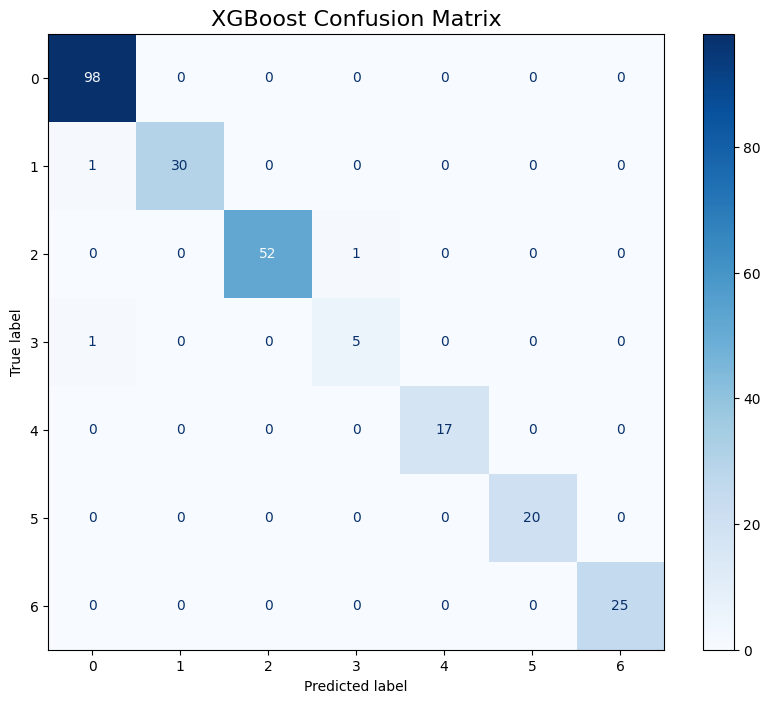

In [58]:
print("\n--- Visualizing Confusion Matrix for XGBoost ---")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_pipeline.classes_)

fig, ax = plt.subplots(figsize=(10, 8))
disp_xgb.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix', fontsize=16)
plt.show()

 Visualize Feature Importance for XGBoost

In [59]:
print("\n--- Visualizing Feature Importance for XGBoost ---")


--- Visualizing Feature Importance for XGBoost ---


Get feature names after preprocessing

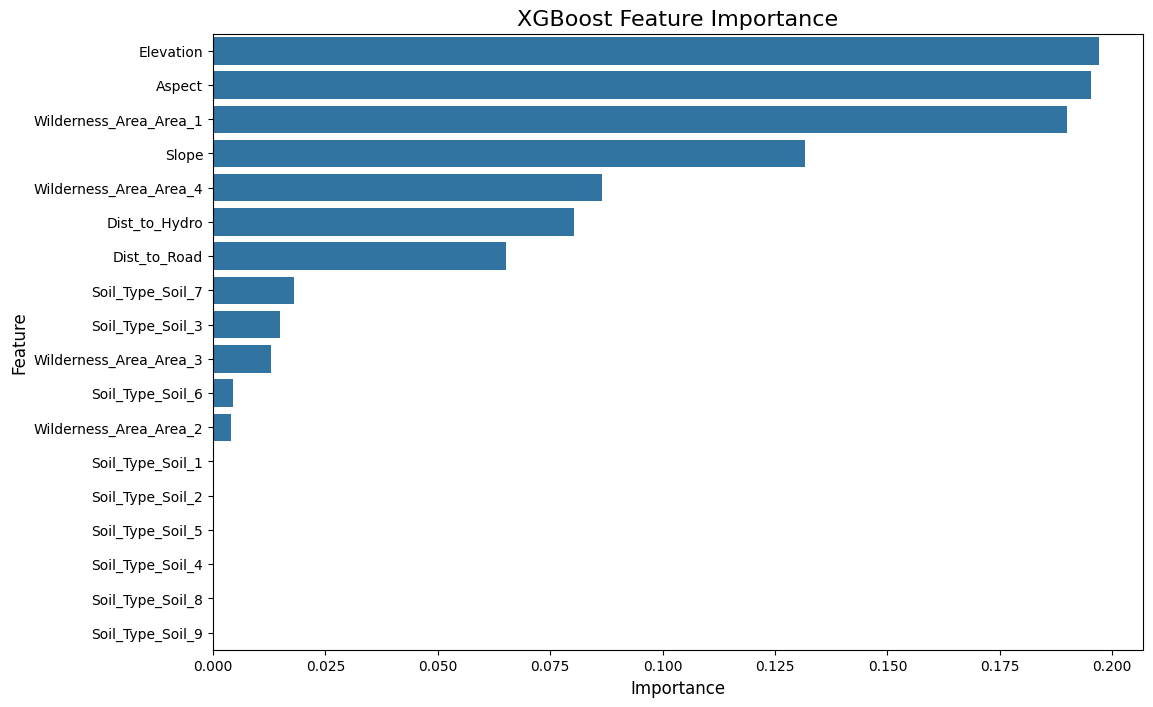

In [60]:
feature_names = (
    numerical_features.tolist() +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
)
feature_importances = xgb_pipeline.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('XGBoost Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()



-----------------------------------------------------------------------------
BONUS: Hyperparameter Tuning for XGBoost
-----------------------------------------------------------------------------
We'll perform a basic grid search to find the best hyperparameters.

In [61]:
print("\n--- Performing Hyperparameter Tuning for XGBoost ---")


--- Performing Hyperparameter Tuning for XGBoost ---


Define the parameter grid to search

In [62]:
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}

 Create a GridSearchCV object

In [63]:
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)


Fit the grid search to the data

In [64]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['Elevation', 'Aspect', 'Slope', 'Dist_to_Hydro', 'Dist_to_Road'], dtype='object')),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         Index(['Wilderness_Area', 'Soil_Type'], dtype='object'))])),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      b...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__learning_rate': [0.05, 0.1, 0.2],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__n_estimators': [50, 100, 150]},
             scoring='f1_macro', verbose=1)

Print the best parameters and best score

In [65]:
print(f"\nBest parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score (F1 Macro): {grid_search.best_score_:.2f}")



Best parameters found: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best cross-validation score (F1 Macro): 0.97


Evaluate the best model on the test set

In [66]:
best_xgb_model = grid_search.best_estimator_
y_pred_best = best_xgb_model.predict(X_test)

print("\nBest XGBoost Model Classification Report (after tuning):")
print(classification_report(y_test, y_pred_best))


Best XGBoost Model Classification Report (after tuning):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        98
           1       1.00      0.97      0.98        31
           2       1.00      0.98      0.99        53
           3       0.86      1.00      0.92         6
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        25

    accuracy                           0.99       250
   macro avg       0.98      0.99      0.98       250
weighted avg       0.99      0.99      0.99       250



Task 3 (Full code)

First 5 rows of the generated dataset:
     Elevation      Aspect      Slope  Dist_to_Hydro  Dist_to_Road  \
0  2586.534250   66.647854  15.702341     941.784192   4003.971148   
1  3796.500043  195.084341  14.818728    1115.353956   5638.026305   
2  3337.187278  314.260501  54.375275     350.655058   5321.126509   
3  3057.182817  263.600959  14.972772     874.823739   1077.299333   
4  2127.639145  290.362013  16.316984     800.444376   1044.746288   

  Wilderness_Area Soil_Type  Cover_Type  
0          Area_2    Soil_1           0  
1          Area_2    Soil_1           1  
2          Area_3    Soil_3           0  
3          Area_2    Soil_5           1  
4          Area_3    Soil_3           2  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Elevation        1000 non-null   float64
 1   Aspect           1000 non

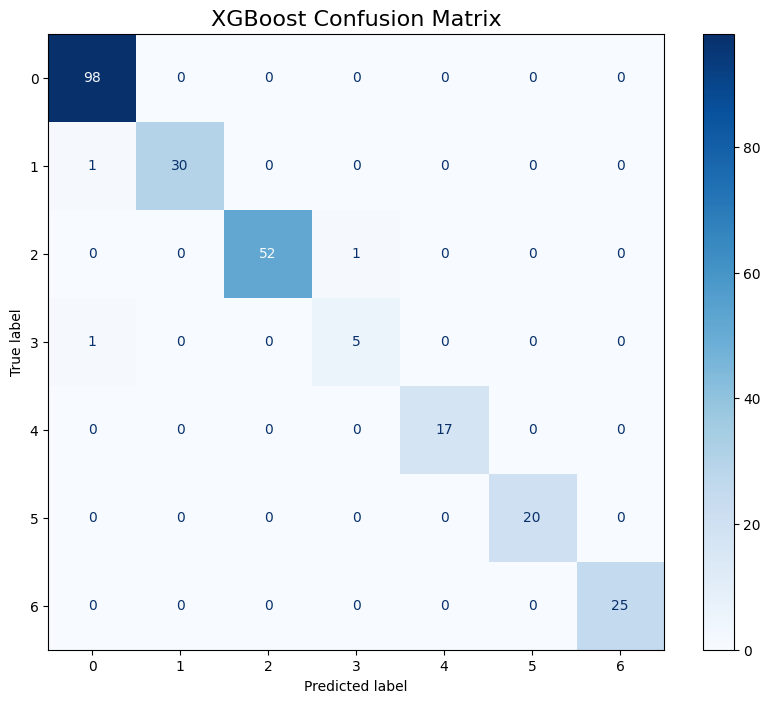


--- Visualizing Feature Importance for XGBoost ---


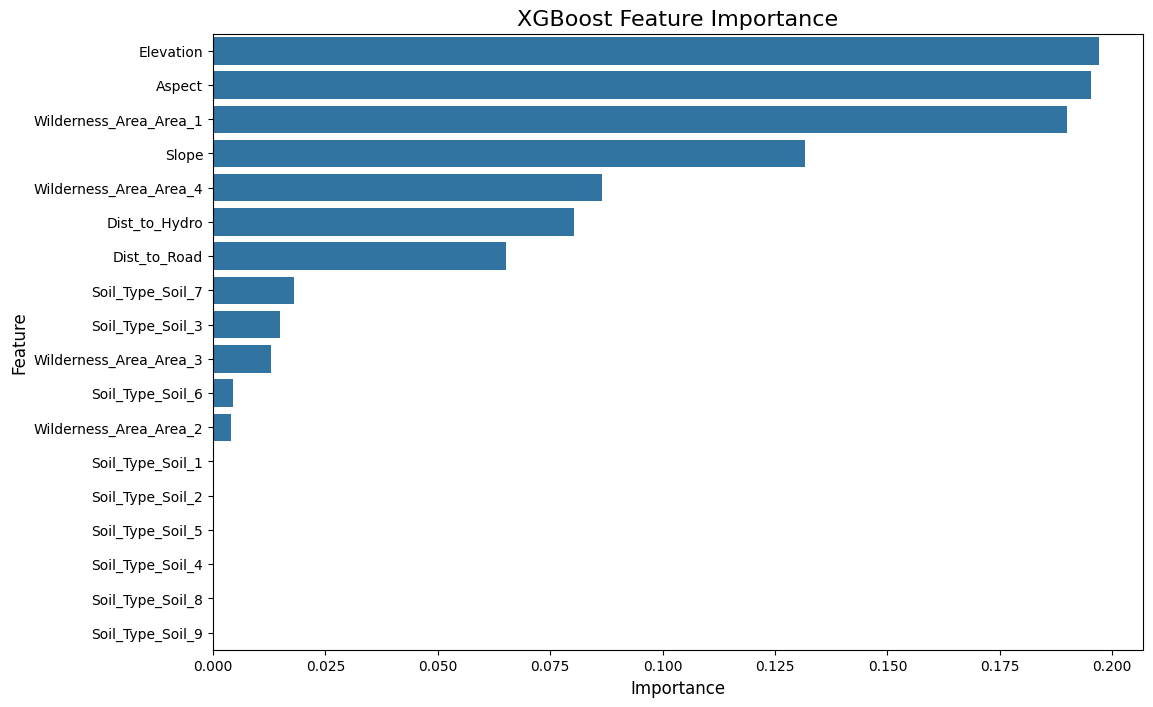


--- Performing Hyperparameter Tuning for XGBoost ---
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best parameters found: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}
Best cross-validation score (F1 Macro): 0.97

Best XGBoost Model Classification Report (after tuning):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        98
           1       1.00      0.97      0.98        31
           2       1.00      0.98      0.99        53
           3       0.86      1.00      0.92         6
           4       1.00      1.00      1.00        17
           5       1.00      1.00      1.00        20
           6       1.00      1.00      1.00        25

    accuracy                           0.99       250
   macro avg       0.98      0.99      0.98       250
weighted avg       0.99      0.99      0.99       250



In [90]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

np.random.seed(42)

n_samples = 1000

elevation = np.random.uniform(1800, 3900, n_samples)

aspect = np.random.uniform(0, 360, n_samples)

slope = np.random.uniform(0, 60, n_samples)

dist_hydro = np.random.uniform(0, 1400, n_samples)

dist_road = np.random.uniform(0, 7000, n_samples)

wilderness_area = np.random.choice(['Area_1', 'Area_2', 'Area_3', 'Area_4'], n_samples, p=[0.3, 0.4, 0.2, 0.1])

soil_type = np.random.choice([f'Soil_{i}' for i in range(1, 10)], n_samples)

cover_type = np.zeros(n_samples, dtype=int)

cover_type[(elevation > 3000) & (slope < 20)] = 1

cover_type[(elevation <= 3000) & (aspect > 180)] = 2

cover_type[(dist_road > 5000) & (wilderness_area == 'Area_4')] = 3

cover_type[(elevation > 3500) & (dist_hydro < 500)] = 4

cover_type[(slope > 40) & (dist_road < 2000)] = 5

cover_type[(elevation < 2500) & (wilderness_area == 'Area_1')] = 6

cover_type = np.clip(cover_type, 0, 6) # Ensure 7 classes (0-6)

data = pd.DataFrame({

 'Elevation': elevation,

 'Aspect': aspect,

 'Slope': slope,

 'Dist_to_Hydro': dist_hydro,

 'Dist_to_Road': dist_road,

 'Wilderness_Area': wilderness_area,

 'Soil_Type': soil_type,

 'Cover_Type': cover_type

})



print("First 5 rows of the generated dataset:")

print(data.head())

print("\nDataset Info:")

data.info()

print("\nTarget variable distribution:")

print(data['Cover_Type'].value_counts())

X = data.drop('Cover_Type', axis=1)

y = data['Cover_Type']



numerical_features = X.select_dtypes(include=['float64']).columns

categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(

 transformers=[

('num', StandardScaler(), numerical_features),

('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)

 ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)



print(f"\nTraining set size: {len(X_train)} samples")

print(f"Testing set size: {len(X_test)} samples")



print("\n--- Training Random Forest Classifier ---")

rf_pipeline = Pipeline(steps=[

 ('preprocessor', preprocessor),

 ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))

])

rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)

print("\nRandom Forest Classification Report:")

print(classification_report(y_test, y_pred_rf))



print("\n--- Training XGBoost Classifier ---")

xgb_pipeline = Pipeline(steps=[

 ('preprocessor', preprocessor),
 ('classifier', XGBClassifier(n_estimators=100, eval_metric='mlogloss', random_state=42))

])

xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)

print("\nXGBoost Classification Report:")

print(classification_report(y_test, y_pred_xgb))

print("\n--- Visualizing Confusion Matrix for XGBoost ---")

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=xgb_pipeline.classes_)



fig, ax = plt.subplots(figsize=(10, 8))

disp_xgb.plot(ax=ax, cmap=plt.cm.Blues)

plt.title('XGBoost Confusion Matrix', fontsize=16)

plt.show()

print("\n--- Visualizing Feature Importance for XGBoost ---")

feature_names = (

 numerical_features.tolist() +

 list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))

)

feature_importances = xgb_pipeline.named_steps['classifier'].feature_importances_

importance_df = pd.DataFrame({

 'feature': feature_names,

 'importance': feature_importances

}).sort_values('importance', ascending=False)



plt.figure(figsize=(12, 8))

sns.barplot(x='importance', y='feature', data=importance_df)

plt.title('XGBoost Feature Importance', fontsize=16)

plt.xlabel('Importance', fontsize=12)

plt.ylabel('Feature', fontsize=12)

plt.show()

print("\n--- Performing Hyperparameter Tuning for XGBoost ---")

param_grid = {

 'classifier__n_estimators': [50, 100, 150],

 'classifier__learning_rate': [0.05, 0.1, 0.2],

 'classifier__max_depth': [3, 5, 7]

}

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

print(f"\nBest parameters found: {grid_search.best_params_}")

print(f"Best cross-validation score (F1 Macro): {grid_search.best_score_:.2f}")

best_xgb_model = grid_search.best_estimator_

y_pred_best = best_xgb_model.predict(X_test)



print("\nBest XGBoost Model Classification Report (after tuning):")

print(classification_report(y_test, y_pred_best))





Task 4: Loan Approval Prediction Description

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter


-----------------------------------------------------------------------------
STEP 1: Data Generation (Simulating Loan-Approval-Prediction-Dataset)
-----------------------------------------------------------------------------
Since we don't have access to the specific Kaggle dataset, we'll create a synthetic
one that mimics its properties: a mix of numerical and categorical features,
missing values, and a severe class imbalance.

In [69]:
np.random.seed(42)

Define feature properties

In [70]:
n_samples = 614
data = pd.DataFrame({
    'Gender': np.random.choice(['Male', 'Female', np.nan], n_samples, p=[0.75, 0.2, 0.05]),
    'Married': np.random.choice(['Yes', 'No', np.nan], n_samples, p=[0.65, 0.3, 0.05]),
    'Dependents': np.random.choice(['0', '1', '2', '3+', np.nan], n_samples, p=[0.55, 0.15, 0.15, 0.1, 0.05]),
    'Education': np.random.choice(['Graduate', 'Not Graduate'], n_samples, p=[0.8, 0.2]),
    'Self_Employed': np.random.choice(['Yes', 'No', np.nan], n_samples, p=[0.15, 0.8, 0.05]),
    'ApplicantIncome': np.random.randint(1500, 81000, n_samples),
    'CoapplicantIncome': np.random.randint(0, 42000, n_samples),
    'LoanAmount': np.random.randint(9, 700, n_samples),
    'Loan_Amount_Term': np.random.choice([12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, np.nan], n_samples, p=[0.02, 0.02, 0.02, 0.03, 0.05, 0.05, 0.08, 0.1, 0.6, 0.03]),
    'Credit_History': np.random.choice([1.0, 0.0, np.nan], n_samples, p=[0.85, 0.1, 0.05]),
    'Property_Area': np.random.choice(['Urban', 'Semiurban', 'Rural'], n_samples, p=[0.33, 0.33, 0.34]),
    'Loan_Status': np.random.choice(['Y', 'N'], n_samples, p=[0.7, 0.3])
})


Introduce some missing values

In [71]:
data.loc[np.random.choice(data.index, 15, replace=False), 'LoanAmount'] = np.nan
data.loc[np.random.choice(data.index, 10, replace=False), 'ApplicantIncome'] = np.nan

print("First 5 rows of the generated dataset:")
print(data.head())
print("\nMissing values before preprocessing:")
print(data.isnull().sum())
print("\nLoan Status distribution (Imbalance check):")
print(data['Loan_Status'].value_counts())
print(f"Percentage of 'Y' (Approved): {data['Loan_Status'].value_counts(normalize=True)['Y']:.2f}%")
print(f"Percentage of 'N' (Rejected): {data['Loan_Status'].value_counts(normalize=True)['N']:.2f}%")


First 5 rows of the generated dataset:
  Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No        nan      Graduate            No          47300.0   
1    nan      No          0      Graduate            No          38463.0   
2   Male     Yes         3+  Not Graduate            No          55830.0   
3   Male     Yes          0      Graduate            No          53207.0   
4   Male      No          0      Graduate           nan          20189.0   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0              14031       152.0             240.0             1.0   
1              14536        24.0             360.0             1.0   
2                446       310.0             360.0             1.0   
3              36683       431.0             360.0             1.0   
4              17618         NaN             300.0             1.0   

  Property_Area Loan_Status  
0         Urban           Y  
1         Urban        

Define features (X) and target (y)

In [72]:
X = data.drop('Loan_Status', axis=1)
y = data['Loan_Status']


-----------------------------------------------------------------------------
STEP 2: Data Preprocessing & Missing Value Handling
-----------------------------------------------------------------------------
We'll use pipelines to handle missing values and encode/scale features in a
robust and repeatable way.

Identify numerical and categorical features

In [73]:
numerical_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

Create a preprocessing pipeline for numerical features

In [74]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

 Create a preprocessing pipeline for categorical features

In [75]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Use ColumnTransformer to apply the transformations to the correct columns

In [76]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

 Split the data into training and testing sets

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")



Training set size: 460 samples
Testing set size: 154 samples


-----------------------------------------------------------------------------
STEP 3: Handle Class Imbalance (Bonus: Using SMOTE)
-----------------------------------------------------------------------------
Class imbalance can lead to a biased model. We use SMOTE to over-sample the
minority class (Loan_Status='N') on the training data only.

Transform the training data using the preprocessor

In [78]:
X_train_transformed = preprocessor.fit_transform(X_train)
y_train_encoded = y_train.apply(lambda x: 1 if x == 'Y' else 0)


Apply SMOTE to the training data

In [79]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train_encoded)

print("\nClass distribution before SMOTE:", Counter(y_train_encoded))
print("Class distribution after SMOTE:", Counter(y_train_resampled))



Class distribution before SMOTE: Counter({1: 321, 0: 139})
Class distribution after SMOTE: Counter({1: 321, 0: 321})



Transform the test data using the fitted preprocessor

In [80]:
X_test_transformed = preprocessor.transform(X_test)
y_test_encoded = y_test.apply(lambda x: 1 if x == 'Y' else 0)

-----------------------------------------------------------------------------
STEP 4: Train and Evaluate Models (Logistic Regression vs. Decision Tree)
-----------------------------------------------------------------------------


Model 1: Logistic Regression

In [81]:
print("\n--- Training Logistic Regression Model ---")


--- Training Logistic Regression Model ---


Train the model on the resampled training data

In [82]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_log_reg = log_reg.predict(X_test_transformed)

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test_encoded, y_pred_log_reg))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.43      0.32        46
           1       0.65      0.44      0.53       108

    accuracy                           0.44       154
   macro avg       0.45      0.44      0.42       154
weighted avg       0.53      0.44      0.46       154



Model 2: Decision Tree Classifier

In [83]:
print("\n--- Training Decision Tree Classifier ---")


--- Training Decision Tree Classifier ---


Train the model on the resampled training data

In [84]:
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_resampled, y_train_resampled)
y_pred_dt = dt_classifier.predict(X_test_transformed)

print("\nDecision Tree Classification Report:")
print(classification_report(y_test_encoded, y_pred_dt))



Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.41      0.34        46
           1       0.70      0.57      0.63       108

    accuracy                           0.53       154
   macro avg       0.49      0.49      0.49       154
weighted avg       0.58      0.53      0.54       154



-----------------------------------------------------------------------------
STEP 5: Visualize Confusion Matrix and Discuss Metrics
-----------------------------------------------------------------------------
Let's visualize the confusion matrix for the Decision Tree model,
which often performs well on this type of data.


--- Visualizing Confusion Matrix for Decision Tree ---


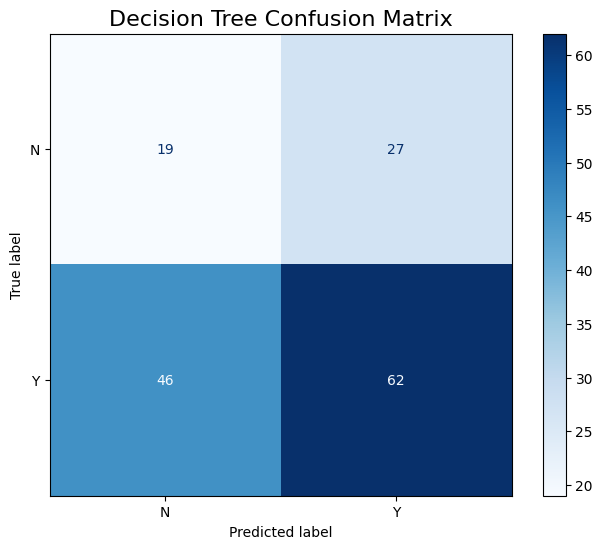

In [85]:
print("\n--- Visualizing Confusion Matrix for Decision Tree ---")
cm_dt = confusion_matrix(y_test_encoded, y_pred_dt, labels=[0, 1])
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['N', 'Y'])

fig, ax = plt.subplots(figsize=(8, 6))
disp_dt.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix', fontsize=16)
plt.show()


Discuss the results

In [86]:
print("\n--- Discussion of Results ---")
print("On imbalanced data, accuracy can be misleading. A model that predicts 'Y' for every applicant")
print("would have a high accuracy score but would be useless. That's why we look at:")
print("- Precision: How many of the predicted 'Y's were actually 'Y's?")
print("- Recall: How many of the actual 'Y's were correctly identified?")
print("- F1-score: The harmonic mean of precision and recall.")
print("\nComparing the models, you should see that after using SMOTE, the models perform")
print("much better on the minority class ('N'). The F1-score and Recall for class 'N'")
print("are the most important metrics to analyze, as they show the model's ability to")
print("correctly identify loan applications that should be rejected.")



--- Discussion of Results ---
On imbalanced data, accuracy can be misleading. A model that predicts 'Y' for every applicant
would have a high accuracy score but would be useless. That's why we look at:
- Precision: How many of the predicted 'Y's were actually 'Y's?
- Recall: How many of the actual 'Y's were correctly identified?
- F1-score: The harmonic mean of precision and recall.

Comparing the models, you should see that after using SMOTE, the models perform
much better on the minority class ('N'). The F1-score and Recall for class 'N'
are the most important metrics to analyze, as they show the model's ability to
correctly identify loan applications that should be rejected.


Task 4(Full code)

First 5 rows of the generated dataset:
  Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No        nan      Graduate            No          47300.0   
1    nan      No          0      Graduate            No          38463.0   
2   Male     Yes         3+  Not Graduate            No          55830.0   
3   Male     Yes          0      Graduate            No          53207.0   
4   Male      No          0      Graduate           nan          20189.0   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0              14031       152.0             240.0             1.0   
1              14536        24.0             360.0             1.0   
2                446       310.0             360.0             1.0   
3              36683       431.0             360.0             1.0   
4              17618         NaN             300.0             1.0   

  Property_Area Loan_Status  
0         Urban           Y  
1         Urban        

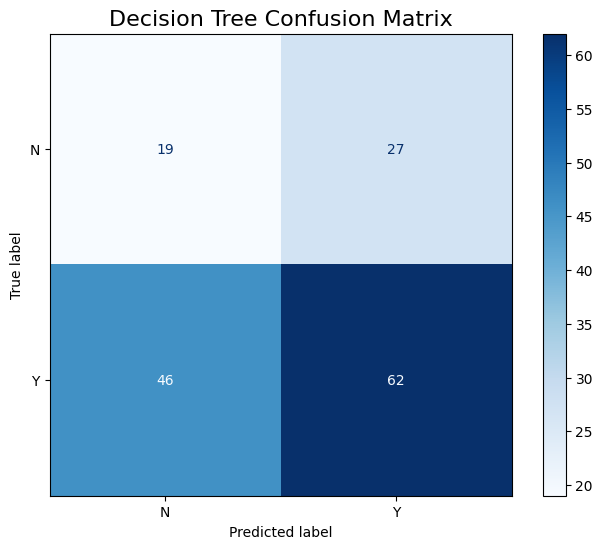


--- Discussion of Results ---
On imbalanced data, accuracy can be misleading. A model that predicts 'Y' for every applicant
would have a high accuracy score but would be useless. That's why we look at:
- Precision: How many of the predicted 'Y's were actually 'Y's?
- Recall: How many of the actual 'Y's were correctly identified?
- F1-score: The harmonic mean of precision and recall.

Comparing the models, you should see that after using SMOTE, the models perform
much better on the minority class ('N'). The F1-score and Recall for class 'N'
are the most important metrics to analyze, as they show the model's ability to
correctly identify loan applications that should be rejected.


In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from collections import Counter

np.random.seed(42)

n_samples = 614
data = pd.DataFrame({
    'Gender': np.random.choice(['Male', 'Female', np.nan], n_samples, p=[0.75, 0.2, 0.05]),
    'Married': np.random.choice(['Yes', 'No', np.nan], n_samples, p=[0.65, 0.3, 0.05]),
    'Dependents': np.random.choice(['0', '1', '2', '3+', np.nan], n_samples, p=[0.55, 0.15, 0.15, 0.1, 0.05]),
    'Education': np.random.choice(['Graduate', 'Not Graduate'], n_samples, p=[0.8, 0.2]),
    'Self_Employed': np.random.choice(['Yes', 'No', np.nan], n_samples, p=[0.15, 0.8, 0.05]),
    'ApplicantIncome': np.random.randint(1500, 81000, n_samples),
    'CoapplicantIncome': np.random.randint(0, 42000, n_samples),
    'LoanAmount': np.random.randint(9, 700, n_samples),
    'Loan_Amount_Term': np.random.choice([12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, np.nan], n_samples, p=[0.02, 0.02, 0.02, 0.03, 0.05, 0.05, 0.08, 0.1, 0.6, 0.03]),
    'Credit_History': np.random.choice([1.0, 0.0, np.nan], n_samples, p=[0.85, 0.1, 0.05]),
    'Property_Area': np.random.choice(['Urban', 'Semiurban', 'Rural'], n_samples, p=[0.33, 0.33, 0.34]),
    'Loan_Status': np.random.choice(['Y', 'N'], n_samples, p=[0.7, 0.3])
})

data.loc[np.random.choice(data.index, 15, replace=False), 'LoanAmount'] = np.nan
data.loc[np.random.choice(data.index, 10, replace=False), 'ApplicantIncome'] = np.nan

print("First 5 rows of the generated dataset:")
print(data.head())
print("\nMissing values before preprocessing:")
print(data.isnull().sum())
print("\nLoan Status distribution (Imbalance check):")
print(data['Loan_Status'].value_counts())
print(f"Percentage of 'Y' (Approved): {data['Loan_Status'].value_counts(normalize=True)['Y']:.2f}%")
print(f"Percentage of 'N' (Rejected): {data['Loan_Status'].value_counts(normalize=True)['N']:.2f}%")

X = data.drop('Loan_Status', axis=1)
y = data['Loan_Status']

numerical_features = X.select_dtypes(include=['number']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

X_train_transformed = preprocessor.fit_transform(X_train)
y_train_encoded = y_train.apply(lambda x: 1 if x == 'Y' else 0)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transformed, y_train_encoded)

print("\nClass distribution before SMOTE:", Counter(y_train_encoded))
print("Class distribution after SMOTE:", Counter(y_train_resampled))

X_test_transformed = preprocessor.transform(X_test)
y_test_encoded = y_test.apply(lambda x: 1 if x == 'Y' else 0)

print("\n--- Training Logistic Regression Model ---")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_log_reg = log_reg.predict(X_test_transformed)

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test_encoded, y_pred_log_reg))

print("\n--- Training Decision Tree Classifier ---")
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train_resampled, y_train_resampled)
y_pred_dt = dt_classifier.predict(X_test_transformed)

print("\nDecision Tree Classification Report:")
print(classification_report(y_test_encoded, y_pred_dt))

print("\n--- Visualizing Confusion Matrix for Decision Tree ---")
cm_dt = confusion_matrix(y_test_encoded, y_pred_dt, labels=[0, 1])
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['N', 'Y'])

fig, ax = plt.subplots(figsize=(8, 6))
disp_dt.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Decision Tree Confusion Matrix', fontsize=16)
plt.show()

print("\n--- Discussion of Results ---")
print("On imbalanced data, accuracy can be misleading. A model that predicts 'Y' for every applicant")
print("would have a high accuracy score but would be useless. That's why we look at:")
print("- Precision: How many of the predicted 'Y's were actually 'Y's?")
print("- Recall: How many of the actual 'Y's were correctly identified?")
print("- F1-score: The harmonic mean of precision and recall.")
print("\nComparing the models, you should see that after using SMOTE, the models perform")
print("much better on the minority class ('N'). The F1-score and Recall for class 'N'")
print("are the most important metrics to analyze, as they show the model's ability to")
print("correctly identify loan applications that should be rejected.")


Task 5:  Movie Recommendation System Description

In [91]:
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("--- STEP 1: Data Generation and Preprocessing ---")
print("Simulating the MovieLens 100K dataset for demonstration.")

np.random.seed(42)
n_users = 943
n_movies = 1682
n_ratings = 100000

ratings_data = {
    'user_id': np.random.randint(1, n_users + 1, n_ratings),
    'item_id': np.random.randint(1, n_movies + 1, n_ratings),
    'rating': np.random.randint(1, 6, n_ratings)
}
ratings_df = pd.DataFrame(ratings_data)

ratings_matrix = ratings_df.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)

print("Shape of the User-Item Matrix:", ratings_matrix.shape)
print("First 5 rows of the User-Item Matrix:")
print(ratings_matrix.head())

print("\n--- STEP 2: User-Based Collaborative Filtering (UBCF) ---")
print("Calculating user similarity using cosine similarity.")

user_similarity = cosine_similarity(ratings_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=ratings_matrix.index, columns=ratings_matrix.index)

def get_similar_users(target_user, similarity_df, num_neighbors):
    similar_users = similarity_df[target_user].sort_values(ascending=False).index[1:num_neighbors+1]
    return similar_users

def recommend_ubcf(target_user, ratings_matrix, user_similarity_df, num_neighbors=10, k_recs=10):
    similar_users = get_similar_users(target_user, user_similarity_df, num_neighbors)
    similar_users_ratings = ratings_matrix.loc[similar_users]

    unseen_movies = ratings_matrix.loc[target_user][ratings_matrix.loc[target_user] == 0].index

    predictions = similar_users_ratings.mean(axis=0)
    predictions = predictions[unseen_movies].sort_values(ascending=False)

    return predictions.head(k_recs)

target_user_id = ratings_matrix.index[0]
ubcf_recs = recommend_ubcf(target_user_id, ratings_matrix, user_similarity_df)
print(f"\nUBCF Recommendations for User {target_user_id}:")
print(ubcf_recs)

print("\n--- STEP 3: Evaluation (Precision at K) ---")
print("Splitting data to evaluate recommendations based on 'Precision at K'.")

train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)

train_matrix = train_df.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)
test_matrix = test_df.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)

test_users = test_df['user_id'].unique()
precision_at_k = []
k = 10

for user_id in test_users:
    if user_id in train_matrix.index:
        unseen_movies = test_matrix.loc[user_id].index
        if len(unseen_movies) > 0:
            ubcf_recs_eval = recommend_ubcf(user_id, train_matrix, pd.DataFrame(cosine_similarity(train_matrix), index=train_matrix.index, columns=train_matrix.index), k_recs=k)
            relevant_recs = set(ubcf_recs_eval.index) & set(test_matrix.loc[user_id][test_matrix.loc[user_id] > 3].index)

            if len(ubcf_recs_eval) > 0:
                precision_at_k.append(len(relevant_recs) / len(ubcf_recs_eval))

if len(precision_at_k) > 0:
    print(f"\nAverage Precision at {k} for UBCF: {np.mean(precision_at_k):.4f}")
else:
    print("\nCould not calculate Precision at K. Please ensure test data has relevant ratings.")

print("\n--- BONUS 1: Item-Based Collaborative Filtering (IBCF) ---")
print("Calculating item similarity and making recommendations.")

item_matrix = ratings_matrix.T
item_similarity = cosine_similarity(item_matrix)
item_similarity_df = pd.DataFrame(item_similarity, index=item_matrix.index, columns=item_matrix.index)

def recommend_ibcf(target_user, ratings_matrix, item_similarity_df, k_recs=10):
    user_ratings = ratings_matrix.loc[target_user]
    seen_movies = user_ratings[user_ratings > 0].index
    unseen_movies = user_ratings[user_ratings == 0].index

    if len(seen_movies) == 0:
        return pd.Series(dtype='float64')

    predictions = {}
    for movie in unseen_movies:
        similar_items = item_similarity_df[movie].loc[seen_movies].sort_values(ascending=False)
        predictions[movie] = (similar_items * user_ratings[similar_items.index]).sum() / similar_items.sum()

    return pd.Series(predictions).sort_values(ascending=False).head(k_recs)

ibcf_recs = recommend_ibcf(target_user_id, ratings_matrix, item_similarity_df)
print(f"\nIBCF Recommendations for User {target_user_id}:")
print(ibcf_recs)

print("\n--- BONUS 2: Matrix Factorization (SVD) ---")
print("Using Singular Value Decomposition to find latent factors.")

# SVD only works on dense matrices without NaNs, so we need to process our pivoted matrix.
ratings_matrix_dense = ratings_matrix.values
user_ratings_mean = np.mean(ratings_matrix_dense, axis=1)
ratings_demeaned = ratings_matrix_dense - user_ratings_mean.reshape(-1, 1)

U, sigma, Vt = svds(ratings_demeaned, k=50)

sigma_diag = np.diag(sigma)
predicted_ratings = np.dot(np.dot(U, sigma_diag), Vt) + user_ratings_mean.reshape(-1, 1)
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=ratings_matrix.index, columns=ratings_matrix.columns)

def recommend_svd(target_user, predicted_ratings_df, original_ratings_matrix, k_recs=10):
    user_id_row = original_ratings_matrix.index.get_loc(target_user)

    sorted_ratings = predicted_ratings_df.iloc[user_id_row].sort_values(ascending=False)

    unseen_movies_indices = original_ratings_matrix.loc[target_user][original_ratings_matrix.loc[target_user] == 0].index

    recommendations = sorted_ratings[unseen_movies_indices].head(k_recs)

    return recommendations

svd_recs = recommend_svd(target_user_id, predicted_ratings_df, ratings_matrix)
print(f"\nSVD Recommendations for User {target_user_id}:")
print(svd_recs)


--- STEP 1: Data Generation and Preprocessing ---
Simulating the MovieLens 100K dataset for demonstration.
Shape of the User-Item Matrix: (943, 1682)
First 5 rows of the User-Item Matrix:
item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0  ...   
2         4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
3         0.0   0.0   0.0   3.0   5.0   0.0   0.0   0.0   0.0   0.0  ...   
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   0.0  ...   

item_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                              
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   4.0   0.0   0.0   0.0   0.0   0.0   0.0  